# Analyse des sorties ParFlow (.pfb)
Le format natif des sorties ParFlow est le .pfb. Ce sont des matrices binaires composées d'un en-tête et de la matrice (1D, 2D, ou 3D). Il peut être utile de les convertir en netcdf, format pris en charge par plusieurs librairies de traitement de données

In [20]:
import numpy as np
import os,glob,struct
import xarray as xr
import pandas as pd
import datetime as dt

fonction pour lire un .pfb:

In [21]:
def PFB_read(pfb_file_path, flag):

    #print("**This code DOES handle subgrids**")
    # flag = 1: return array + header
    # flag = 0: return array only
    
    hdr_dict = {}
    
    with open(pfb_file_path,'rb') as pfbf:
        hdr_dict['X0'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['Y0'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['Z0'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['nx'] = struct.unpack('>i', pfbf.read(4))[0]
        hdr_dict['ny'] = struct.unpack('>i', pfbf.read(4))[0]
        hdr_dict['nz'] = struct.unpack('>i', pfbf.read(4))[0]
        hdr_dict['dx'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['dy'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['dz'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['ns'] = struct.unpack('>i', pfbf.read(4))[0]
        ns = hdr_dict['ns']
        #print(ns)
        nx = hdr_dict['nx']
        ny = hdr_dict['ny']
        nz = hdr_dict['nz']
        
        if nx == 0:
            nx = int(raw_input("What should the NX be?"))
            hdr_dict['nx'] = nx
        if ny == 0:
            ny = int(raw_input("What should the NY be?"))
            hdr_dict['ny'] = ny
        if nz ==0:
            nz =int(raw_input("What should the NZ be?"))
            hdr_dict['nz'] = nz
        
        X0 = hdr_dict['X0']
        #print "len_x, len_y, len_z, nx ny nz --> %f %f %f %i %i %i" %(len_x, len_x, len_x, nx, ny, nz)
        
        pfb_array = np.zeros((nx, ny, nz))
        
        for subgrids in range(ns):
            hdr_dict['ix'] = struct.unpack('>i', pfbf.read(4))[0]
            ix = hdr_dict['ix']
            hdr_dict['iy'] = struct.unpack('>i', pfbf.read(4))[0]
            iy = hdr_dict['iy']
            #print(iy)
            hdr_dict['iz'] = struct.unpack('>i', pfbf.read(4))[0]
            iz = hdr_dict['iz']
            hdr_dict['nx2'] = struct.unpack('>i', pfbf.read(4))[0]
            nx2 = hdr_dict['nx2']
            hdr_dict['ny2'] = struct.unpack('>i', pfbf.read(4))[0]
            ny2 = hdr_dict['ny2']
            #print(ny2)
            hdr_dict['nz2'] = struct.unpack('>i', pfbf.read(4))[0]
            nz2 = hdr_dict['nz2']
            hdr_dict['rx'] = struct.unpack('>i', pfbf.read(4))[0]
            rx = hdr_dict['rx']
            hdr_dict['ry'] = struct.unpack('>i', pfbf.read(4))[0]
            ry = hdr_dict['ry']
            hdr_dict['rz'] = struct.unpack('>i', pfbf.read(4))[0]
            rz = hdr_dict['rz']
            #print "ix iy iz nx2 ny2 nz2 rx ry rz --> %i %i %i %i %i %i %i %i %i\n" %(ix,iy, iz, nx2, ny2, nz2, rx,ry, rz)
            for lays in range(nz2):
                for rows in range(ny2):
                    for cols in range(nx2):
                        val = struct.unpack('>d', pfbf.read(8))[0]
                        #q = raw_input(val)
                        pfb_array[(cols+ix), (rows + iy), (nz2-(lays + iz)-1)] = val
                        #pfb_array[(cols+ix-1), (nx2-(iy)-1), (nz2-(lays + iz)-1)] = val
                        #pfb_array[(rows + iy-1), (cols+ix-1), (nz2-(lays + iz)-1)] = val
                        #print val
                        
    if flag ==1:
        return(pfb_array, hdr_dict)
    else:
        return(pfb_array)


Quelques paramètres de simulation

In [23]:
datadir = '/home/hectorb/PARFLOW/PROJECTS/Hillslope/bele_nalo_tests/simus/docker_test/'
n_coupled_layers = 22
vdz = np.array([0.01,0.01,0.01,0.01,0.092,0.092,0.092,0.092,0.092,0.16,0.16,0.16,0.16,0.16,0.24,0.24,0.24,0.24,0.24,4.3,4.3,4.3,4.3,4.3])
z = np.cumsum(vdz)-vdz/2
print(z)

[5.000e-03 1.500e-02 2.500e-02 3.500e-02 8.600e-02 1.780e-01 2.700e-01
 3.620e-01 4.540e-01 5.800e-01 7.400e-01 9.000e-01 1.060e+00 1.220e+00
 1.420e+00 1.660e+00 1.900e+00 2.140e+00 2.380e+00 4.650e+00 8.950e+00
 1.325e+01 1.755e+01 2.185e+01]


## Lecture des fichiers pression: 

In [26]:
"""identify files"""
files = glob.glob(os.path.join(datadir,'*press.*.pfb'))
files.sort()
#skip initial condition
files.pop(0)

'/home/hectorb/PARFLOW/PROJECTS/Hillslope/bele_nalo_tests/simus/docker_test/hillslope.out.press.00000.pfb'

In [30]:
"""reads in the first file to have the dimension & initialize"""
d,h=PFB_read(files[0],1)
print(h)

{'X0': 0.0, 'Y0': 0.0, 'Z0': 0.0, 'nx': 1, 'ny': 50, 'nz': 24, 'dx': 10.0, 'dy': 10.0, 'dz': 1.0, 'ns': 2, 'ix': 0, 'iy': 25, 'iz': 0, 'nx2': 1, 'ny2': 25, 'nz2': 24, 'rx': 0, 'ry': 0, 'rz': 0}


In [31]:
pressure_array = np.zeros([h['ny'],h['nz'],len(files)])
"""reads in all files"""
for t,f in enumerate(files):
    d,h=PFB_read(f,1)
    pressure_array[:,:,t] = d[0,:,:]

## Ecriture des pressions (.nc): 

In [32]:
np.arange(start = h['Y0'],stop = h['Y0']+h['ny']*h['dy'],step=h['dy'])
pd.date_range("2005-01-01", periods=len(files))

DatetimeIndex(['2005-01-01', '2005-01-02', '2005-01-03', '2005-01-04',
               '2005-01-05', '2005-01-06', '2005-01-07', '2005-01-08',
               '2005-01-09', '2005-01-10',
               ...
               '2015-12-20', '2015-12-21', '2015-12-22', '2015-12-23',
               '2015-12-24', '2015-12-25', '2015-12-26', '2015-12-27',
               '2015-12-28', '2015-12-29'],
              dtype='datetime64[ns]', length=4015, freq='D')

In [33]:
"""write netcdf"""
ds = xr.Dataset({"press": (("time","z","y"), np.swapaxes(pressure_array,2,0))},
    coords={"y":np.arange(start = h['Y0'],stop = h['Y0']+h['ny']*h['dy'],step=h['dy']),
        "z":-z, 
        "time": pd.date_range("2005-01-01", periods=len(files)),
        "reference_time": pd.Timestamp("2005-01-01")})

ds.press.attrs['units']='m'
ds.y.attrs['units']='meters'
ds.z.attrs['units']='meters'

ds.to_netcdf(os.path.join(datadir,"press.nc"),format="NETCDF4")

## Lecture des fichiers saturation: 

In [34]:
"""identify files"""
files = glob.glob(os.path.join(datadir,'*satur.*.pfb'))
files.sort()
#skip initial condition
files.pop(0)
"""reads in the first file to have the dimension & initialize"""
d,h=PFB_read(files[0],1)

In [35]:
satur_array = np.zeros([h['ny'],h['nz'],len(files)])
"""reads in all files"""
for t,f in enumerate(files):
    d,h=PFB_read(f,1)
    satur_array[:,:,t] = d[0,:,:]

## Ecriture des saturations (.nc): 

In [36]:
"""write netcdf"""
ds = xr.Dataset({"satur": (("time","z","y"), np.swapaxes(satur_array,2,0))},
    coords={"y":np.arange(start = h['Y0'],stop = h['Y0']+h['ny']*h['dy'],step=h['dy']),
        "z":-z, 
        "time": pd.date_range("2005-01-01", periods=len(files)),
        "reference_time": pd.Timestamp("2005-01-01")})

ds.satur.attrs['units']='[-]'
ds.y.attrs['units']='meters'
ds.z.attrs['units']='meters'

ds.to_netcdf(os.path.join(datadir,"satur.nc"),format="NETCDF4")

## Evolution de la saturation

In [37]:
ds

<xarray.Dataset>
Dimensions:         (time: 4015, y: 50, z: 24)
Coordinates:
  * y               (y) float64 0.0 10.0 20.0 30.0 ... 460.0 470.0 480.0 490.0
  * z               (z) float64 -0.005 -0.015 -0.025 ... -13.25 -17.55 -21.85
  * time            (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2015-12-29
    reference_time  datetime64[ns] 2005-01-01
Data variables:
    satur           (time, z, y) float64 0.05164 0.05164 0.05164 ... 0.9 0.9 0.9

In [39]:
import hvplot.xarray
#interpolation optionnelle:
ds2 = ds.interp(z=np.arange(0,-24,-0.2),method='linear')

ds2.satur.hvplot.quadmesh(x='y',y='z',groupby="time",clim=(0,1),widget_type="scrubber",widget_location="bottom",)

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=4014, width=550)
        [2] HSpacer()

## Extraction des niveaux de nappe

In [14]:
ds = xr.open_dataset(os.path.join(datadir,"press.nc"))
ds = ds.assign(WTD = z[-1] - ds.press.isel(z=-1))

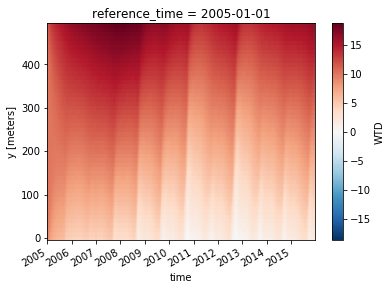

In [15]:
ds.WTD.plot(x='time')

In [16]:
from matplotlib import pyplot as plt
ds.WTD.isel(y=3).plot(label='hill bottom')
ds.WTD.isel(y=47).plot(label='hill top')
plt.gca().legend()
plt.gca().invert_yaxis()

## Lecture des débits journaliers

In [41]:
"""identify files"""
files = glob.glob(os.path.join(datadir,'*overlandsum.*.pfb'))
files.sort()
"""reads in the first file to have the dimension & initialize"""
d,h=PFB_read(files[0],1)
runoff = pd.Series(index=pd.date_range("2005-01-01", periods=len(files)))
"""reads in all files"""
for t,f in enumerate(files):
    d,h=PFB_read(f,1)
    runoff.iloc[t] = np.sum(d[0,:,0])
print(np.shape(d))

/home/hectorb/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


(1, 50, 1)


In [42]:
#runoff.plot()
runoff.loc[runoff.index.year==2006].plot()

## Lecture des variables CLM (evapotranspiration, notamment)
Dans le manuel, les variables CLM écrites sont :
- *eflx_lh_tot* for latent heat flux total [W/m 2 ] 
- *eflx_lwrad_out* for outgoing long-wave radiation [W/m 2 ] 
- *eflx_sh_tot* for sensible heat flux total [W/m 2 ] 
- *eflx_soil_grnd* for ground heat flux [W/m 2 ] 
- *qflx_evap_tot* for total evaporation [mm/s] 
- *qflx_evap_grnd* for ground evaporation without condensation [mm/s] 
- *qflx_evap_soi* for soil evaporation [mm/s] 
- *qflx_evap_veg* for vegetation evaporation [mm/s] 
- *qflx_tran_veg* for vegetation transpiration [mm/s]
- *qflx_infl* for soil infiltration [mm/s]
- *swe_out* for snow water equivalent [mm]
- *t_grnd* for ground surface temperature [K]
- *t_soil* for soil temperature over all layers [K] 

In [43]:
"""identify files"""
files = glob.glob(os.path.join(datadir,'*clm_output*.pfb'))
files.sort()
"""reads in the first file to have the dimension & initialize"""
d,h=PFB_read(files[0],1)
evaptot_array = np.zeros([h['ny'],len(files)])
evapveg_array = np.zeros([h['ny'],len(files)])
evapsoi_array = np.zeros([h['ny'],len(files)])
print(d.shape)
"""reads in all files"""
for t,f in enumerate(files):
    d,h=PFB_read(f,1)
    evaptot_array[:,t] = d[0,:,-5]*60*60
    evapveg_array[:,t] = d[0,:,-8]*60*60
    evapsoi_array[:,t] = d[0,:,-7]*60*60


(1, 50, 35)


## Ecriture des sorties CLM (.nc)

In [44]:
"""write netcdf"""
ds = xr.Dataset({"evaptot": (("time","y"), np.swapaxes(evaptot_array,1,0)),
                 "evapveg": (("time","y"), np.swapaxes(evapveg_array,1,0)),
                 "evapsoil": (("time","y"), np.swapaxes(evapsoi_array,1,0))},
    coords={"y":np.arange(start = h['Y0'],stop = h['Y0']+h['ny']*h['dy'],step=h['dy']),
        "time": pd.date_range("2005-01-01", periods=len(files),freq='1H'),
        "reference_time": pd.Timestamp("2005-01-01")})

ds.evaptot.attrs['units']='mm/h'
ds.evapveg.attrs['units']='mm/h'
ds.evapsoil.attrs['units']='mm/h'
ds.y.attrs['units']='meters'

ds.to_netcdf(os.path.join(datadir,"evapotranspiration.nc"),format="NETCDF4")

In [45]:
ds.evaptot.mean(dim='y').resample(time='D').sum().plot(label='evap_tot')
ds.evapveg.mean(dim='y').resample(time='D').sum().plot(label='evap_veg')
ds.evapsoil.mean(dim='y').resample(time='D').sum().plot(label='evap_soil')
plt.gca().legend()

## Lecture de l'évapotranspiration journaliere

In [46]:
"""identify files"""
files = glob.glob(os.path.join(datadir,'*evaptranssum.*.pfb'))
files.sort()
"""reads in the first file to have the dimension & initialize"""
d,h=PFB_read(files[0],1)
ETsum = pd.Series(index=pd.date_range("2005-01-01", periods=len(files)))
"""reads in all files"""
for t,f in enumerate(files):
    d,h=PFB_read(f,1)
    tmp = np.zeros([h['ny']])
    for k in range(n_coupled_layers):
        tmp+=d[0,:,k]*vdz[k]
    ETsum.iloc[t] = np.mean(tmp)
print(d[0,0,:])

/home/hectorb/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


[-4.70861031 -0.06416807 -0.06416807 -0.06416807 -0.06416807 -0.06416807
 -0.06416807 -0.06416807 -0.06416807 -0.06416807 -0.06416807 -0.06416807
 -0.06416807 -0.06416807 -0.06416807 -0.06416807 -0.06416807 -0.06416807
 -0.06416807  0.          0.          0.          0.          0.        ]


## Lecture des forçages:

In [47]:
""" Read Forcings: """
forcing_headers = {0:'SWin',1:'LWin',2:'P', 3: 'T', 4:'WindX', 5:'WindY',6:'Press', 7:'Hs'}
forc = pd.read_csv(glob.glob(os.sep.join([datadir,'*forc*txt*']))[0],header=None,sep='\t')
forc.rename(columns=forcing_headers,inplace=True)
forc.index=pd.date_range('1/1/2005 00:00:00', periods=len(forc), freq='30min')
P=forc['P']*30*60
forc

SWin   LWin    P       T  WindX  WindY    Press        Hs
2005-01-01 00:00:00  -3.0  331.3  0.0  291.75    1.0    0.0  96600.0  0.003954
2005-01-01 00:30:00  -3.0  328.8  0.0  290.75    0.6    0.0  96600.0  0.004013
2005-01-01 01:00:00  -2.8  326.5  0.0  290.25    0.6    0.0  96600.0  0.003976
2005-01-01 01:30:00  -2.0  326.0  0.0  289.95    0.8    0.0  96500.0  0.003880
2005-01-01 02:00:00  -2.6  325.4  0.0  289.65    0.9    0.0  96500.0  0.003818
...                   ...    ...  ...     ...    ...    ...      ...       ...
2015-12-31 21:30:00  -3.3  340.9  0.0  294.95    0.7    0.0  96510.0  0.004114
2015-12-31 22:00:00  -3.0  338.1  0.0  294.25    0.6    0.0  96510.0  0.004103
2015-12-31 22:30:00  -2.4  336.0  0.0  293.95    0.9    0.0  96510.0  0.004156
2015-12-31 23:00:00  -2.8  334.5  0.0  293.45    2.0    0.0  96500.0  0.004153
2015-12-31 23:30:00  -3.8  333.2  0.0  293.25    1.7    0.0  96500.0  0.004117

[192816 rows x 8 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f847a03a7f0>,
      dtype=object)

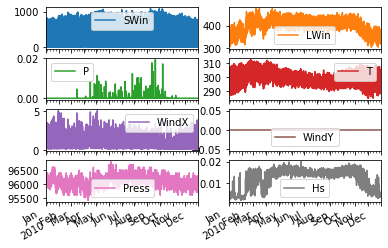

In [48]:
forc.loc[forc.index.year==2010,:].plot(subplots=True, layout=(4,2))

In [49]:
""" correction de l'ET """
ETsum = ETsum*1000/h['dx']/h['dy'] #m3 -> mm

In [50]:
ET = -(ETsum -P.resample('D').sum())

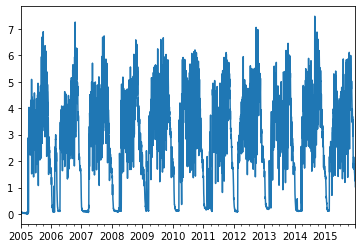

In [51]:
ET.dropna().plot()

## Calcul de la variation de stock

In [52]:
## lectures de variables auxiliaires: 
poro,h=PFB_read(glob.glob(os.path.join(datadir,'*poro*.pfb'))[0],1)
specstor,h=PFB_read(glob.glob(os.path.join(datadir,'*specific*.pfb'))[0],1)
specstor,h=PFB_read(glob.glob(os.path.join(datadir,'*specific*.pfb'))[0],1)
dz_mult_arr,h = PFB_read(glob.glob(os.path.join(datadir,'*dz_mult.pfb'))[0],1)
dz_mult_arr.shape

(1, 50, 24)

In [53]:

# loop over time
nt = satur_array.shape[-1]

stock = np.zeros([nt])
for t in range(nt):
    # underground storage
    stock[t] = (h['dx']*h['dy']*h['dz']*dz_mult_arr[0,:,:]*poro[0,:,:]*satur_array[:,:,t]).sum(axis=0).sum(axis=0)
    # poroelastic storage
    tmp1 = (h['dx']*h['dy']*h['dz']*dz_mult_arr[0,:,:]*specstor[0,:,:]*satur_array[:,:,t]*pressure_array[:,:,t])
    #~ tmp[tmp<0]=0.
    stock[t]+=tmp1.sum(axis=0).sum(axis=0)
    # surface storage
    tmp2 = h['dx']*h['dy']*pressure_array[:,0,t]
    tmp2[tmp2<0]=0
    stock[t]+=tmp2.sum(axis=0)

In [54]:
stock = stock * 1000/h['dx']/h['dy']/h['ny']
stock = stock-stock[0]
#stock = stock[1::]
stock = pd.Series(stock)
#stock.index=pd.date_range('1/1/2005 00:00:00', periods=nt-1, freq='D')
stock.index=pd.date_range('1/1/2005 00:00:00', periods=nt, freq='D')

stock = stock.sort_index()

In [55]:
stock.plot()

## Calcul du bilan

In [56]:
Q = runoff* 1000/h['dx']/h['dy']/h['ny']
Budg = pd.DataFrame({'P':P.resample('Y').sum(),'ET':ET.resample('Y').sum(),'Q':Q.resample('Y').sum(),'WSC':np.nan})
for i, y in enumerate(np.sort(stock.index.year.unique())):
    if i ==0:
         Budg['WSC'][Budg.index.year==y] = stock[stock.index.year==y][-1]
    else:
         Budg['WSC'][Budg.index.year==y] = stock[stock.index.year==y][-1] - stock[stock.index.year==y-1][-1] 
Budg.index=Budg.index.year
Budg['closure'] = Budg['P']- Budg['ET']-Budg['Q']-Budg['WSC']
Budg

P           ET           Q         WSC       closure
2005  1213.8912   972.598257  116.160355  125.230614 -9.802643e-02
2006   913.0176   969.496570   11.775183  -68.254152 -1.125921e-07
2007  1213.8912  1002.138725  131.271955   80.480523 -3.593391e-06
2008  1210.6476   967.062193  137.300154  106.285254 -1.156979e-06
2009  1495.9260  1193.206102  246.005761   56.714138 -4.865219e-07
2010  1527.1380  1101.672892  358.497442   66.967665  6.027154e-07
2011   934.3242  1021.513196   30.054392 -117.243388  5.485245e-08
2012  1422.4896  1151.535371  140.928252  130.025976  6.110748e-07
2013   994.7970  1060.476910   43.626775 -109.306685  2.152279e-07
2014  1151.8704  1085.663648   88.123186  -21.916434 -9.229250e-08
2015  1290.2922  1105.378838  202.690481  -17.777118 -7.185714e-07

The bad closure in year 1 is likely explained by not taking into acount initial condition

In [57]:
def plot_clustered_stacked(dfall, labels=None,  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    fig = plt.figure(figsize=(10,4))
    axe = fig.add_subplot(111)

    for df in dfall : # for each data frame
        if isinstance(df, pd.DataFrame):
            axe = df.plot(kind="bar",
            linewidth=0,
            stacked=True,
            ax=axe,
            legend=False,
            grid=False,
            **kwargs)  # make bar plots
        else:
             axe = df.plot(kind="bar",
             linewidth=0,
             stacked=True,
             ax=axe,
             legend=False,
             grid=False,
	     color='b',
             **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe


Text(0, 0.5, 'mm')

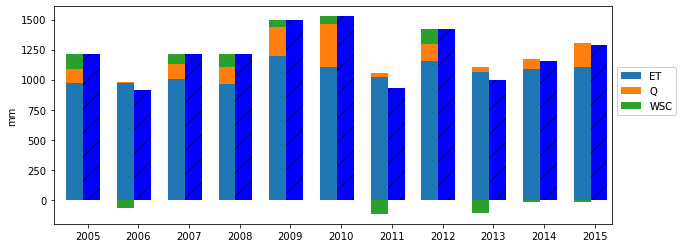

In [58]:
ax=plot_clustered_stacked([Budg.loc[:,['ET','Q','WSC']],Budg['P']])
ax.set_ylabel('mm')